# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import pandas as pd
import os
# from scipy.misc import imread, imresize
from skimage import io
import datetime
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

#### Defining a root directory

In [4]:
root_dir = '../input/project-data/Project_data/'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_path = root_dir + '/train.csv'
val_path = root_dir + '/val.csv'
train_doc = np.random.permutation(open(train_path).readlines())
val_doc = np.random.permutation(open(val_path).readlines())
batch_size = 10

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
#data resizing - Resizing all the images, so we can have all the images in a specific size
def crop_resize_img(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]  #crop the image
    resized_image = cv2.resize(img, (rows,cols)) # resize the image
    return resized_image

In [7]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(5,25)) #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = 120
    z = 120
    
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)//batch_size) # calculate the number of batches
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,rows,cols,channel_color)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = crop_resize_img(image) #resizing the image
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            

        
        # write the code for the remaining data points which are left after full batches
        if int(len(t)%batch_size!=0):
            rest_videos_count = int(len(t)%batch_size)
            for folder in range(rest_videos_count): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + ((num_batches)*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + ((num_batches)*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = crop_resize_img(image) #resizing the image
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = root_dir + '/train'
val_path = root_dir + '/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


#### Creating a function to plot various accuracies

In [9]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# 1st Method: CNN

# Model 1: CNN with SGD optimiser

#### Defining various parameters to be used frequently

In [10]:
frame = 20
rows = 120
cols = 120
channel_color = 3
num_classes = 5

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Bidirectional,LSTM, SimpleRNN, GRU
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

model = Sequential()

model.add(Conv3D(32, kernel_size = (3,3,3), padding = "same", activation = "relu" , input_shape = (frame, rows, cols, channel_color)))
model.add(BatchNormalization())

#HL1
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#HL2
model.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

#Fully connected
model.add(Flatten())
model.add(Dense(256,  activation = "relu"))

#output layer
model.add(Dense(num_classes, activation = "softmax"))

In [12]:
optimiser = "adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 32)  128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 120, 120, 64)  55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 120, 120, 64)  256       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 60, 60, 128)   221312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 60, 60, 128)   5

#### Generating training and validation data using generator function

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#### Defining the path where various models will be saved

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", fractor = 0.5, patience = 2, cooldown = 1, verbose = 1)
callbacks_list = [checkpoint, LR]

#### Logic to calculate number of epochs in both training and validation data

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
    
print("Train Epoch value: ", steps_per_epoch)
print("Val Epoch value: ", validation_steps)

Train Epoch value:  67
Val Epoch value:  10


#### Fitting the model

In [16]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project-data/Project_data/train ; batch size = 10
Epoch 1/50
67/67 [==============================] - 138s 2s/step - loss: 209.1986 - categorical_accuracy: 0.3493 - val_loss: 324.0385 - val_categorical_accuracy: 0.1900

Epoch 00001: val_loss improved from inf to 324.03854, saving model to model_init_2021-08-0101_41_51.298361/model-00001-128.99835-0.40000-324.03854-0.19000.h5
Epoch 2/50
67/67 [==============================] - 66s 986ms/step - loss: 21.9157 - categorical_accuracy: 0.5176 - val_loss: 377.8936 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 324.03854
Epoch 3/50
67/67 [==============================] - 65s 978ms/step - loss: 7.0363 - categorical_accuracy: 0.4359 - val_loss: 45.7135 - val_categorical_accuracy: 0.2200

Epoch 00003: val_loss improved from 324.03854 to 45.71345, saving model to model_init_2021-08-0101_41_51.298361/model-00003-5.52919-0.43433-45.71345-0.22000.h5
Epoch 4/50
67/67 [===========================

#### Plotting the performance of the model

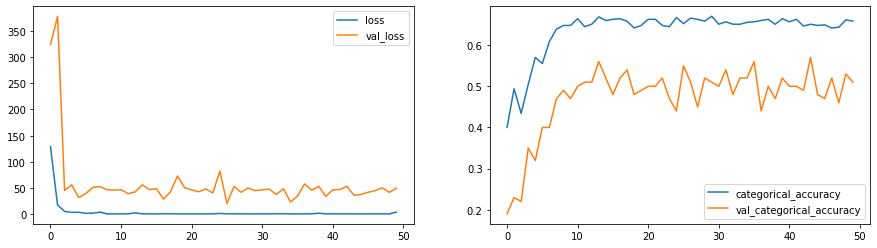

In [17]:
plot(history)

In [18]:
def model_result(model_name ,accuracy, loss, val_accuracy, val_loss):
    model_detail_dic = {"Model Name" : model_name,
                   "Model Accuracy" : accuracy * 100,
                   "Model Loss" : loss * 100 ,
                   "Val Accuracy" : val_accuracy * 100,
                   "Val Loss" : val_loss * 100}

    df = pd.DataFrame([model_detail_dic])
    return df
    

#### Creating a dataframe to store various parameters

In [19]:
model_detail_df = pd.DataFrame()

In [20]:
df1 = model_result("Model_1_SGD",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

    Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0  Model_1_SGD       65.820897  429.153824     50.999999  4982.62291


# Model 2: CNN + LSTM Network()

In [21]:
model2 = Sequential()

model2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = (frame, rows, cols, channel_color)))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

model2.add(TimeDistributed(Flatten()))


model2.add(LSTM(128))

model2.add(Dense(128,activation='relu'))
model2.add(Dropout(0.3))

model2.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 64)   

#### Fitting the model

In [22]:
history = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
67/67 [==============================] - 58s 836ms/step - loss: 1.4657 - categorical_accuracy: 0.3671 - val_loss: 1.6725 - val_categorical_accuracy: 0.2600

Epoch 00001: val_loss improved from 20.57560 to 1.67251, saving model to model_init_2021-08-0101_41_51.298361/model-00001-1.41244-0.39552-1.67251-0.26000.h5
Epoch 2/50
67/67 [==============================] - 52s 792ms/step - loss: 1.2221 - categorical_accuracy: 0.4734 - val_loss: 1.7431 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 1.67251
Epoch 3/50
67/67 [==============================] - 55s 838ms/step - loss: 1.1242 - categorical_accuracy: 0.5670 - val_loss: 1.8114 - val_categorical_accuracy: 0.1800

Epoch 00003: val_loss did not improve from 1.67251

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/50
67/67 [==============================] - 54s 814ms/step - loss: 0.9424 - categorical_accuracy: 0.6495 - val_loss: 1.7655 - val_categorical_accur

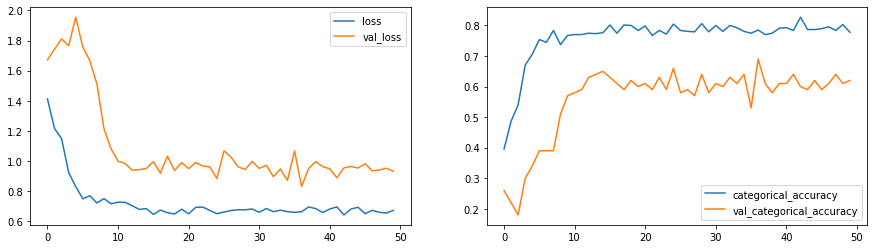

In [23]:
plot(history)

In [24]:
df1 = model_result("Model_2_CNN_LSTM",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

         Model Name  Model Accuracy  Model Loss  Val Accuracy     Val Loss
0       Model_1_SGD       65.820897  429.153824     50.999999  4982.622910
0  Model_2_CNN_LSTM       77.761191   67.165470     62.000000    93.240935


# Model 3: CNN + LSTM Network(Added more cells, Removed Hidden Layer, Added Dropout)

In [25]:
model3 = Sequential()

model3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),input_shape = (frame, rows, cols, channel_color)))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

model3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))
model3.add(Dropout(0.3))


model3.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))
model3.add(Dropout(0.3))

model3.add(TimeDistributed(Flatten()))


model3.add(LSTM(512))

model3.add(Dense(512,activation='relu'))
model3.add(Dropout(0.3))

model3.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 20, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 20, 120, 120, 32)  128       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 20, 60, 60, 64)    18496     
_________________________________________________________________
time_distributed_17 (TimeDis (None, 20, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 30, 30, 64)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 30, 30, 64)   

#### Fitting the model

In [26]:
history = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
67/67 [==============================] - 57s 831ms/step - loss: 1.7407 - categorical_accuracy: 0.2232 - val_loss: 2.2864 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss did not improve from 0.83101
Epoch 2/50
67/67 [==============================] - 55s 833ms/step - loss: 1.3316 - categorical_accuracy: 0.4440 - val_loss: 2.1238 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 0.83101
Epoch 3/50
67/67 [==============================] - 53s 800ms/step - loss: 1.1802 - categorical_accuracy: 0.4897 - val_loss: 2.3894 - val_categorical_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 0.83101
Epoch 4/50
67/67 [==============================] - 54s 813ms/step - loss: 1.0735 - categorical_accuracy: 0.5842 - val_loss: 2.1150 - val_categorical_accuracy: 0.2400

Epoch 00004: val_loss did not improve from 0.83101
Epoch 5/50
67/67 [==============================] - 53s 805ms/step - loss: 0.9885 - categorical_accuracy: 0.5872 - val_loss:

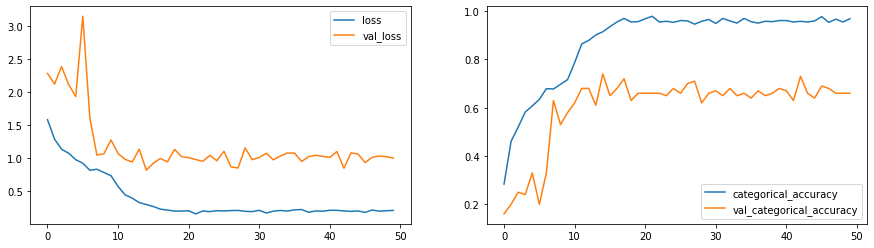

In [27]:
plot(history)

In [28]:
df1 = model_result( "Model_3_CNN_LSTM_Tune", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

              Model Name  Model Accuracy  Model Loss  Val Accuracy  \
0            Model_1_SGD       65.820897  429.153824     50.999999   
0       Model_2_CNN_LSTM       77.761191   67.165470     62.000000   
0  Model_3_CNN_LSTM_Tune       96.865672   20.883286     66.000003   

      Val Loss  
0  4982.622910  
0    93.240935  
0   100.236797  


# 2nd Method: CNN + RNN

# Model 4: CNN + SimpleRNN Network

In [29]:
input_shape = (frame, rows, cols, channel_color)

In [30]:
model4 = Sequential()

model4.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = (frame, rows, cols, channel_color)))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

model4.add(TimeDistributed(Flatten()))


model4.add(SimpleRNN(256))

model4.add(Dense(256,activation='relu'))
model4.add(Dropout(0.3))

model4.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_23 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_24 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_25 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_28 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 20, 30, 30, 64)   

#### Fitting the model

In [31]:
history = model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
67/67 [==============================] - 57s 837ms/step - loss: 1.6428 - categorical_accuracy: 0.3257 - val_loss: 3.3827 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss did not improve from 0.81679
Epoch 2/50
67/67 [==============================] - 56s 841ms/step - loss: 1.0568 - categorical_accuracy: 0.5676 - val_loss: 4.1440 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 0.81679
Epoch 3/50
67/67 [==============================] - 55s 828ms/step - loss: 0.9047 - categorical_accuracy: 0.6233 - val_loss: 3.2277 - val_categorical_accuracy: 0.2200

Epoch 00003: val_loss did not improve from 0.81679
Epoch 4/50
67/67 [==============================] - 56s 843ms/step - loss: 0.7796 - categorical_accuracy: 0.6940 - val_loss: 3.3067 - val_categorical_accuracy: 0.2400

Epoch 00004: val_loss did not improve from 0.81679
Epoch 5/50
67/67 [==============================] - 54s 815ms/step - loss: 0.7111 - categorical_accuracy: 0.7024 - val_loss:

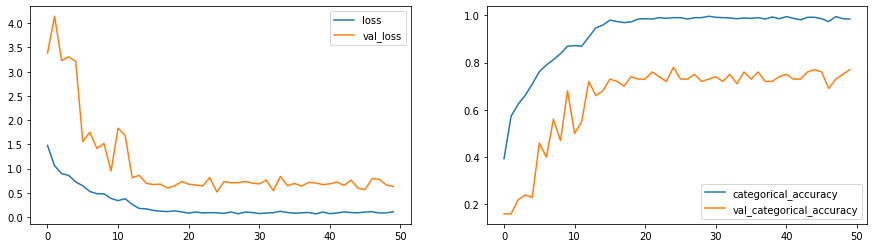

In [32]:
plot(history)

In [33]:
df1 = model_result("Model_4_CNN_RNN",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

              Model Name  Model Accuracy  Model Loss  Val Accuracy  \
0            Model_1_SGD       65.820897  429.153824     50.999999   
0       Model_2_CNN_LSTM       77.761191   67.165470     62.000000   
0  Model_3_CNN_LSTM_Tune       96.865672   20.883286     66.000003   
0        Model_4_CNN_RNN       98.358208   11.060181     76.999998   

      Val Loss  
0  4982.622910  
0    93.240935  
0   100.236797  
0    62.807477  


In [34]:
print(model_detail_df.head(20))

              Model Name  Model Accuracy  Model Loss  Val Accuracy  \
0            Model_1_SGD       65.820897  429.153824     50.999999   
0       Model_2_CNN_LSTM       77.761191   67.165470     62.000000   
0  Model_3_CNN_LSTM_Tune       96.865672   20.883286     66.000003   
0        Model_4_CNN_RNN       98.358208   11.060181     76.999998   

      Val Loss  
0  4982.622910  
0    93.240935  
0   100.236797  
0    62.807477  


# Model 5 : CNN + GRU Network 

In [35]:
model5 = Sequential()

model5.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape = (frame, rows, cols, channel_color)))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

model5.add(TimeDistributed(Flatten()))


model5.add(GRU(256))

model5.add(Dense(256,activation='relu'))
model5.add(Dropout(0.4))

model5.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_38 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_40 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 20, 30, 30, 64)   

#### Fitting the model

In [36]:
history = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
67/67 [==============================] - 57s 838ms/step - loss: 1.7058 - categorical_accuracy: 0.3029 - val_loss: 2.2932 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss did not improve from 0.51455
Epoch 2/50
67/67 [==============================] - 53s 805ms/step - loss: 1.1966 - categorical_accuracy: 0.4921 - val_loss: 1.7803 - val_categorical_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 0.51455
Epoch 3/50
67/67 [==============================] - 55s 836ms/step - loss: 0.9793 - categorical_accuracy: 0.6286 - val_loss: 2.0758 - val_categorical_accuracy: 0.2900

Epoch 00003: val_loss did not improve from 0.51455
Epoch 4/50
67/67 [==============================] - 54s 820ms/step - loss: 0.8520 - categorical_accuracy: 0.6765 - val_loss: 2.5518 - val_categorical_accuracy: 0.2400

Epoch 00004: val_loss did not improve from 0.51455

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/50
67/67 [========================

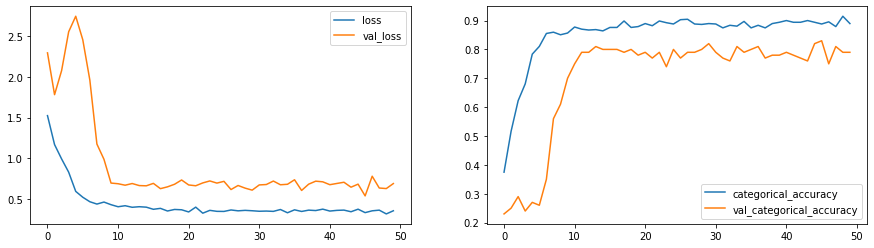

In [37]:
plot(history)

In [38]:
df1 = model_result("Model_5_CNN_GRU", history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

              Model Name  Model Accuracy  Model Loss  Val Accuracy  \
0            Model_1_SGD       65.820897  429.153824     50.999999   
0       Model_2_CNN_LSTM       77.761191   67.165470     62.000000   
0  Model_3_CNN_LSTM_Tune       96.865672   20.883286     66.000003   
0        Model_4_CNN_RNN       98.358208   11.060181     76.999998   
0        Model_5_CNN_GRU       88.955224   35.587654     79.000002   

      Val Loss  
0  4982.622910  
0    93.240935  
0   100.236797  
0    62.807477  
0    68.959051  


# Model 6 : CNN + GRU Network(Added more cells, Added Hidden Layer, Added Dropout)

In [39]:
model6 = Sequential()

model6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'),input_shape = (frame, rows, cols, channel_color)))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))

model6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
model6.add(Dropout(0.5))

model6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
model6.add(Dropout(0.5))

model6.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
model6.add(Dropout(0.5))


model6.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
model6.add(Dropout(0.5))

model6.add(TimeDistributed(Flatten()))


model6.add(GRU(512))

model6.add(Dense(512,activation='relu'))
model6.add(Dropout(0.5))

model6.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_49 (TimeDis (None, 20, 120, 120, 64)  1792      
_________________________________________________________________
time_distributed_50 (TimeDis (None, 20, 120, 120, 64)  256       
_________________________________________________________________
time_distributed_51 (TimeDis (None, 20, 60, 60, 64)    0         
_________________________________________________________________
time_distributed_52 (TimeDis (None, 20, 60, 60, 64)    36928     
_________________________________________________________________
time_distributed_53 (TimeDis (None, 20, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_54 (TimeDis (None, 20, 30, 30, 64)    0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 30, 30, 64)   

#### Fitting the model

In [40]:
history = model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
67/67 [==============================] - 59s 841ms/step - loss: 1.9890 - categorical_accuracy: 0.2575 - val_loss: 3.3129 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss did not improve from 0.51455
Epoch 2/50
67/67 [==============================] - 54s 816ms/step - loss: 1.3225 - categorical_accuracy: 0.4495 - val_loss: 4.1354 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 0.51455
Epoch 3/50
67/67 [==============================] - 55s 832ms/step - loss: 1.2390 - categorical_accuracy: 0.4762 - val_loss: 3.7994 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 0.51455

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/50
67/67 [==============================] - 55s 837ms/step - loss: 0.8337 - categorical_accuracy: 0.6837 - val_loss: 3.4279 - val_categorical_accuracy: 0.2500

Epoch 00007: val_loss did not improve from 0.51455
Epoch 8/50
67/67 [========================

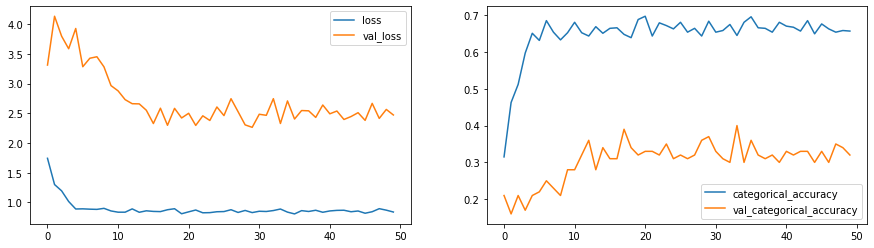

In [41]:
plot(history)

In [42]:
df1 = model_result("Model_6_CNN_GRU_Tuning",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

               Model Name  Model Accuracy  Model Loss  Val Accuracy  \
0             Model_1_SGD       65.820897  429.153824     50.999999   
0        Model_2_CNN_LSTM       77.761191   67.165470     62.000000   
0   Model_3_CNN_LSTM_Tune       96.865672   20.883286     66.000003   
0         Model_4_CNN_RNN       98.358208   11.060181     76.999998   
0         Model_5_CNN_GRU       88.955224   35.587654     79.000002   
0  Model_6_CNN_GRU_Tuning       65.671641   83.744723     31.999999   

      Val Loss  
0  4982.622910  
0    93.240935  
0   100.236797  
0    62.807477  
0    68.959051  
0   247.223473  


# Model 7 : Adding more Hidden Layer

In [43]:
# Adding more layer to the architecture 

model7 = Sequential()


model7.add(Conv3D(16, kernel_size=(3,3,3), padding='same', activation='relu',input_shape = (20,120,120,3)))
model7.add(BatchNormalization())

model7.add(MaxPooling3D(pool_size=(2, 2, 2)))
## h1,2
model7.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model7.add(BatchNormalization())

model7.add(Conv3D(32, kernel_size=(3,3,3), padding='same', activation='relu'))
model7.add(BatchNormalization())

model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

## h3,4
model7.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model7.add(BatchNormalization())


model7.add(Conv3D(64, kernel_size=(3,3,3), padding='same', activation='relu'))
model7.add(BatchNormalization())

model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

## h5,6
model7.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model7.add(BatchNormalization())

model7.add(Conv3D(128, kernel_size=(3,3,3), padding='same', activation='relu'))
model7.add(BatchNormalization())

model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model7.add(Flatten())
model7.add(Dense(256,kernel_regularizer=l2(0.01),activation='relu'))
model7.add(Dropout(0.50))

model7.add(Dense(5, activation = 'softmax'))

optimiser = 'sgd'
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_23 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_24 (Batc (None, 10, 60, 60, 32)    128       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 60, 60, 32)    27680     
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 60, 60, 32)   

#### Fitting the model

In [44]:

history = model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
67/67 [==============================] - 57s 832ms/step - loss: 9.8999 - categorical_accuracy: 0.2728 - val_loss: 7.5261 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss did not improve from 0.51455
Epoch 2/50
67/67 [==============================] - 54s 818ms/step - loss: 6.0836 - categorical_accuracy: 0.4966 - val_loss: 6.2820 - val_categorical_accuracy: 0.3200

Epoch 00002: val_loss did not improve from 0.51455
Epoch 3/50
67/67 [==============================] - 55s 824ms/step - loss: 5.6911 - categorical_accuracy: 0.5915 - val_loss: 6.1821 - val_categorical_accuracy: 0.3700

Epoch 00003: val_loss did not improve from 0.51455
Epoch 4/50
67/67 [==============================] - 56s 847ms/step - loss: 5.5433 - categorical_accuracy: 0.6355 - val_loss: 5.9720 - val_categorical_accuracy: 0.3200

Epoch 00004: val_loss did not improve from 0.51455
Epoch 5/50
67/67 [==============================] - 56s 843ms/step - loss: 5.4322 - categorical_accuracy: 0.6464 - val_loss:

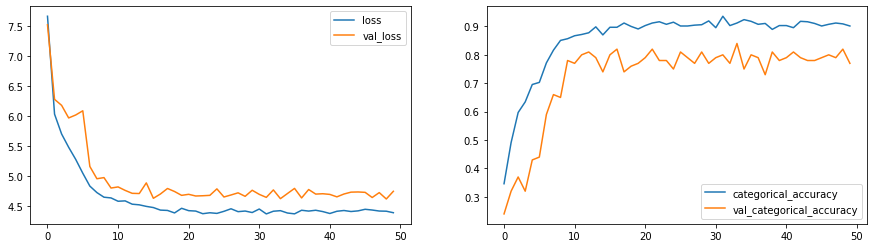

In [45]:
plot(history)

In [46]:
df1 = model_result("Model_7_Add_HL",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

               Model Name  Model Accuracy  Model Loss  Val Accuracy  \
0             Model_1_SGD       65.820897  429.153824     50.999999   
0        Model_2_CNN_LSTM       77.761191   67.165470     62.000000   
0   Model_3_CNN_LSTM_Tune       96.865672   20.883286     66.000003   
0         Model_4_CNN_RNN       98.358208   11.060181     76.999998   
0         Model_5_CNN_GRU       88.955224   35.587654     79.000002   
0  Model_6_CNN_GRU_Tuning       65.671641   83.744723     31.999999   
0          Model_7_Add_HL       90.149254  439.155579     76.999998   

      Val Loss  
0  4982.622910  
0    93.240935  
0   100.236797  
0    62.807477  
0    68.959051  
0   247.223473  
0   474.871635  


# Model 8: CNN + SimpleRNN Network(Added more cells, Added Dropout in HL)

In [47]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Bidirectional,LSTM, SimpleRNN, GRU
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers
model8 = Sequential()

model8.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'),input_shape = (frame, rows, cols, channel_color)))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))

model8.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))
model8.add(Dropout(0.2))


model8.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))
model8.add(Dropout(0.2))

model8.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((2, 2))))
model8.add(Dropout(0.2))

model8.add(TimeDistributed(Flatten()))


model8.add(SimpleRNN(512))

model8.add(Dense(512,activation='relu'))
model8.add(Dropout(0.3))

model8.add(Dense(5, activation='softmax'))


optimiser = 'adam'
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_65 (TimeDis (None, 20, 120, 120, 32)  896       
_________________________________________________________________
time_distributed_66 (TimeDis (None, 20, 120, 120, 32)  128       
_________________________________________________________________
time_distributed_67 (TimeDis (None, 20, 60, 60, 32)    0         
_________________________________________________________________
time_distributed_68 (TimeDis (None, 20, 60, 60, 64)    18496     
_________________________________________________________________
time_distributed_69 (TimeDis (None, 20, 60, 60, 64)    256       
_________________________________________________________________
time_distributed_70 (TimeDis (None, 20, 30, 30, 64)    0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 30, 30, 64)   

#### Fitting the model

In [48]:
history = model8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
67/67 [==============================] - 57s 841ms/step - loss: 1.8760 - categorical_accuracy: 0.3322 - val_loss: 3.2007 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss did not improve from 0.51455
Epoch 2/50
67/67 [==============================] - 55s 830ms/step - loss: 1.2265 - categorical_accuracy: 0.4576 - val_loss: 3.6877 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 0.51455
Epoch 3/50
67/67 [==============================] - 53s 803ms/step - loss: 1.0725 - categorical_accuracy: 0.5832 - val_loss: 2.9523 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 0.51455
Epoch 4/50
67/67 [==============================] - 55s 835ms/step - loss: 0.9184 - categorical_accuracy: 0.6271 - val_loss: 3.6906 - val_categorical_accuracy: 0.3200

Epoch 00004: val_loss did not improve from 0.51455
Epoch 5/50
67/67 [==============================] - 56s 841ms/step - loss: 0.8783 - categorical_accuracy: 0.6038 - val_loss:

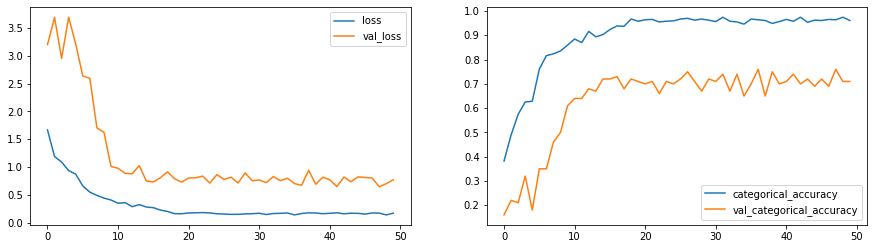

In [49]:
plot(history)

In [50]:
df1 = model_result("Model_8_CNN_RNN_Add_Tuning",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

                   Model Name  Model Accuracy  Model Loss  Val Accuracy  \
0                 Model_1_SGD       65.820897  429.153824     50.999999   
0            Model_2_CNN_LSTM       77.761191   67.165470     62.000000   
0       Model_3_CNN_LSTM_Tune       96.865672   20.883286     66.000003   
0             Model_4_CNN_RNN       98.358208   11.060181     76.999998   
0             Model_5_CNN_GRU       88.955224   35.587654     79.000002   
0      Model_6_CNN_GRU_Tuning       65.671641   83.744723     31.999999   
0              Model_7_Add_HL       90.149254  439.155579     76.999998   
0  Model_8_CNN_RNN_Add_Tuning       96.119404   17.363428     70.999998   

      Val Loss  
0  4982.622910  
0    93.240935  
0   100.236797  
0    62.807477  
0    68.959051  
0   247.223473  
0   474.871635  
0    77.342981  


# 3rd Method: CNN + Transfer Learning

# Model 9: CNN2D + Transfer Learning + LSTM

In [51]:
frames = 20
rows = 50
cols = 50
channel_color = 3
num_classes = 5

In [52]:
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model9 = Sequential()
model9.add(TimeDistributed(mobilenet_transfer,input_shape=(frames,rows,cols,channel_color)))


for layer in model.layers:
	layer.trainable = False


model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D((2, 2),padding='same')))
model9.add(TimeDistributed(Flatten()))

model9.add(LSTM(128))
model9.add(Dropout(0.25))

model9.add(Dense(64,activation='relu'))
model9.add(Dropout(0.25))

model9.add(Dense(num_classes, activation='softmax'))

17227776/17225924 [==============================] - 0s 0us/step


In [53]:
# compile it
model9.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy'])
# summary of model
model9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_78 (TimeDis (None, 20, 1, 1, 1024)    3228864   
_________________________________________________________________
time_distributed_79 (TimeDis (None, 20, 1, 1, 1024)    4096      
_________________________________________________________________
time_distributed_80 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_81 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

In [54]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [55]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
callbacks_list = [checkpoint, LR]

In [56]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [57]:
history3 = model9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project-data/Project_data/train ; batch size = 10
Epoch 1/50
67/67 [==============================] - 53s 730ms/step - loss: 1.6494 - categorical_accuracy: 0.2351 - val_loss: 1.5960 - val_categorical_accuracy: 0.3000

Epoch 00001: val_loss improved from inf to 1.59600, saving model to model_init_2021-08-0101_41_51.298361/model-00001-1.62517-0.25821-1.59600-0.30000.h5
Epoch 2/50
67/67 [==============================] - 45s 680ms/step - loss: 1.5065 - categorical_accuracy: 0.3505 - val_loss: 1.5073 - val_categorical_accuracy: 0.4300

Epoch 00002: val_loss improved from 1.59600 to 1.50730, saving model to model_init_2021-08-0101_41_51.298361/model-00002-1.49774-0.34328-1.50730-0.43000.h5
Epoch 3/50
67/67 [==============================] - 44s 669ms/step - loss: 1.3775 - categorical_accuracy: 0.4436 - val_loss: 1.3133 - val_categorical_accuracy: 0.4900

Epoch 00003: val_loss improved from 1.50730 to 1.31325, saving model to model_init_2021-08-0101_41_51.298361/model

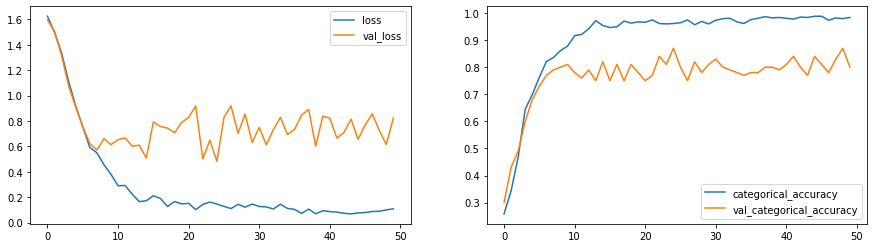

In [58]:
plot(history3)

In [59]:
df3 = model_result("Model_9_LSTM_Transferlearning",history3.history['categorical_accuracy'][-1], history3.history['loss'][-1] , history3.history['val_categorical_accuracy'][-1], history3.history['val_loss'][-1])
model_detail_df = pd.concat([model_detail_df,df3])
print(model_detail_df.head(20))

                      Model Name  Model Accuracy  Model Loss  Val Accuracy  \
0                    Model_1_SGD       65.820897  429.153824     50.999999   
0               Model_2_CNN_LSTM       77.761191   67.165470     62.000000   
0          Model_3_CNN_LSTM_Tune       96.865672   20.883286     66.000003   
0                Model_4_CNN_RNN       98.358208   11.060181     76.999998   
0                Model_5_CNN_GRU       88.955224   35.587654     79.000002   
0         Model_6_CNN_GRU_Tuning       65.671641   83.744723     31.999999   
0                 Model_7_Add_HL       90.149254  439.155579     76.999998   
0     Model_8_CNN_RNN_Add_Tuning       96.119404   17.363428     70.999998   
0  Model_9_LSTM_Transferlearning       98.358208   10.792203     80.000001   

      Val Loss  
0  4982.622910  
0    93.240935  
0   100.236797  
0    62.807477  
0    68.959051  
0   247.223473  
0   474.871635  
0    77.342981  
0    82.242125  


# Model 10: CNN2D + RNN with Transfer learning for GRU

In [60]:
frames = 20
rows = 50
cols = 50
channel_color = 3
num_classes = 5

In [61]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
model10 = Sequential()
model10.add(TimeDistributed(mobilenet_transfer,input_shape=(frames,rows,cols,channel_color)))
model10.add(TimeDistributed(BatchNormalization()))
model10.add(TimeDistributed(MaxPooling2D((2, 2),padding='same')))
model10.add(TimeDistributed(Flatten()))

model10.add(GRU(64))
model10.add(Dropout(0.25))

model10.add(Dense(64,activation='relu'))
model10.add(Dropout(0.25))

model10.add(Dense(num_classes, activation='softmax'))

In [62]:
# compile it
model10.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy'])
# summary of model
model10.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_82 (TimeDis (None, 20, 1, 1, 1024)    3228864   
_________________________________________________________________
time_distributed_83 (TimeDis (None, 20, 1, 1, 1024)    4096      
_________________________________________________________________
time_distributed_84 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_85 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)               

In [63]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [64]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
callbacks_list = [checkpoint, LR]

In [65]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [66]:
history4 = model10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project-data/Project_data/train ; batch size = 10
Epoch 1/50
67/67 [==============================] - 51s 715ms/step - loss: 1.7519 - categorical_accuracy: 0.2372 - val_loss: 1.5824 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 1.58238, saving model to model_init_2021-08-0101_41_51.298361/model-00001-1.66035-0.27761-1.58238-0.27000.h5
Epoch 2/50
67/67 [==============================] - 45s 684ms/step - loss: 1.4993 - categorical_accuracy: 0.3742 - val_loss: 1.3431 - val_categorical_accuracy: 0.4400

Epoch 00002: val_loss improved from 1.58238 to 1.34306, saving model to model_init_2021-08-0101_41_51.298361/model-00002-1.48879-0.37015-1.34306-0.44000.h5
Epoch 3/50
67/67 [==============================] - 45s 683ms/step - loss: 1.3140 - categorical_accuracy: 0.4701 - val_loss: 1.2174 - val_categorical_accuracy: 0.4800

Epoch 00003: val_loss improved from 1.34306 to 1.21743, saving model to model_init_2021-08-0101_41_51.298361/model

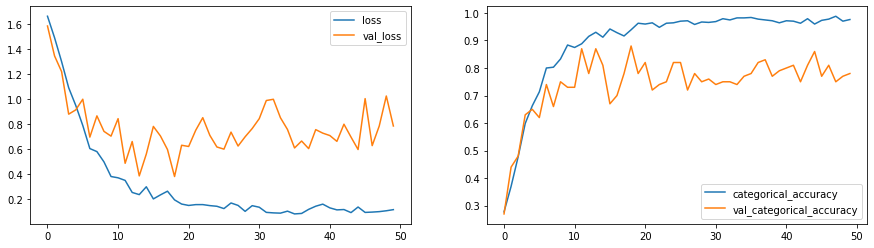

In [67]:
plot(history4)

In [68]:
df4 = model_result("Model_10_GRU_Transferlearning",history4.history['categorical_accuracy'][-1], history4.history['loss'][-1] , history4.history['val_categorical_accuracy'][-1], history4.history['val_loss'][-1])
model_detail_df = pd.concat([model_detail_df,df4])
print(model_detail_df.head(20))

                      Model Name  Model Accuracy  Model Loss  Val Accuracy  \
0                    Model_1_SGD       65.820897  429.153824     50.999999   
0               Model_2_CNN_LSTM       77.761191   67.165470     62.000000   
0          Model_3_CNN_LSTM_Tune       96.865672   20.883286     66.000003   
0                Model_4_CNN_RNN       98.358208   11.060181     76.999998   
0                Model_5_CNN_GRU       88.955224   35.587654     79.000002   
0         Model_6_CNN_GRU_Tuning       65.671641   83.744723     31.999999   
0                 Model_7_Add_HL       90.149254  439.155579     76.999998   
0     Model_8_CNN_RNN_Add_Tuning       96.119404   17.363428     70.999998   
0  Model_9_LSTM_Transferlearning       98.358208   10.792203     80.000001   
0  Model_10_GRU_Transferlearning       97.611940   11.368181     77.999997   

      Val Loss  
0  4982.622910  
0    93.240935  
0   100.236797  
0    62.807477  
0    68.959051  
0   247.223473  
0   474.871635  
0    

# Model 11 :CNN + GRU with (50,50 Image)

In [69]:
frames = 20
rows = 50
cols = 50
channel_color = 3
num_classes = 5

In [70]:
model11 = Sequential()

model11.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'),
                input_shape=(frames,rows,cols,channel_color)))
model11.add(Activation('relu'))
model11.add(BatchNormalization())
model11.add(TimeDistributed(Conv2D(16, (2, 2))))
model11.add(Activation('relu'))
model11.add(BatchNormalization())
model11.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model11.add(Dropout(0.2))

model11.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model11.add(Activation('relu'))
model11.add(BatchNormalization())
model11.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model11.add(Activation('relu'))
model11.add(BatchNormalization())
model11.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model11.add(Dropout(0.2))

model11.add(TimeDistributed(Flatten()))
model11.add(GRU(128,return_sequences=False, dropout=0.5))
model11.add(Dense(64,kernel_regularizer=l2(0.01)))
model11.add(Activation('relu'))
model11.add(Dropout(0.25))
model11.add(Dense(num_classes))
model11.add(Activation('softmax'))

In [71]:
# compile it
model11.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy'])
# summary of model
model11.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_86 (TimeDis (None, 20, 50, 50, 16)    208       
_________________________________________________________________
activation (Activation)      (None, 20, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 20, 50, 50, 16)    64        
_________________________________________________________________
time_distributed_87 (TimeDis (None, 20, 49, 49, 16)    1040      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 49, 49, 16)    0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 20, 49, 49, 16)    64        
_________________________________________________________________
time_distributed_88 (TimeDis (None, 20, 24, 24, 16)  

In [72]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [73]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
callbacks_list = [checkpoint, LR]

In [74]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [75]:
history2 = model11.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project-data/Project_data/train ; batch size = 10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
67/67 [==============================] - 48s 690ms/step - loss: 2.5597 - categorical_accuracy: 0.2319 - val_loss: 2.4835 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 2.48347, saving model to model_init_2021-08-0101_41_51.298361/model-00001-2.45748-0.28358-2.48347-0.24000.h5
Epoch 2/50
67/67 [==============================] - 44s 672ms/step - loss: 2.1051 - categorical_accuracy: 0.4695 - val_loss: 2.7005 - val_categorical_accuracy: 0.1700

Epoch 00002: val_loss did not improve from 2.48347
Epoch 3/50
67/67 [==============================] - 46s 699ms/step - loss: 1.9566 - categorical_accuracy: 0.5459 - val_loss: 2.8444 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 2.48347
Epoch 4/50
67/67 [==============================] - 45s 674ms/step - loss: 1.8258 - categorical_accuracy: 0.5721 - val_loss: 2.9753 - val_categorical_accuracy: 0.3700

Epoch 00004: val_loss did not improve from 2.48347
Epoch 5/50
67/67 [=====

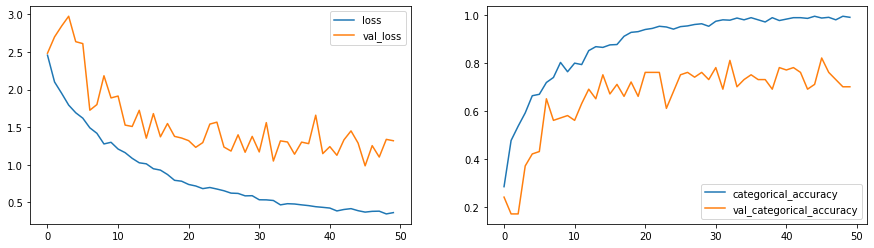

In [76]:
plot(history2)

In [77]:
df2 = model_result("Model_11_GRU",history2.history['categorical_accuracy'][-1], history2.history['loss'][-1] , history2.history['val_categorical_accuracy'][-1], history2.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df2])
print(model_detail_df.head(20))

                      Model Name  Model Accuracy  Model Loss  Val Accuracy  \
0                    Model_1_SGD       65.820897  429.153824     50.999999   
0               Model_2_CNN_LSTM       77.761191   67.165470     62.000000   
0          Model_3_CNN_LSTM_Tune       96.865672   20.883286     66.000003   
0                Model_4_CNN_RNN       98.358208   11.060181     76.999998   
0                Model_5_CNN_GRU       88.955224   35.587654     79.000002   
0         Model_6_CNN_GRU_Tuning       65.671641   83.744723     31.999999   
0                 Model_7_Add_HL       90.149254  439.155579     76.999998   
0     Model_8_CNN_RNN_Add_Tuning       96.119404   17.363428     70.999998   
0  Model_9_LSTM_Transferlearning       98.358208   10.792203     80.000001   
0  Model_10_GRU_Transferlearning       97.611940   11.368181     77.999997   
0                   Model_11_GRU       98.955226   36.311457     69.999999   

      Val Loss  
0  4982.622910  
0    93.240935  
0   100.2367

## Model 12: Model CNN + LSTM with (50,50) Image
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [78]:
frames = 20
rows = 50
cols = 50
channel_color = 3
num_classes = 5

In [79]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'),
                 input_shape=(frames,rows,cols,channel_color)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16, (2, 2))))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(5))
model.add(Activation('softmax'))
 

#Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [80]:
# compile it
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy'])
# summary of model
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_93 (TimeDis (None, 20, 50, 50, 16)    208       
_________________________________________________________________
activation_6 (Activation)    (None, 20, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 20, 50, 50, 16)    64        
_________________________________________________________________
time_distributed_94 (TimeDis (None, 20, 49, 49, 16)    1040      
_________________________________________________________________
activation_7 (Activation)    (None, 20, 49, 49, 16)    0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 20, 49, 49, 16)    64        
_________________________________________________________________
time_distributed_95 (TimeDis (None, 20, 24, 24, 16)  

In [81]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [82]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
callbacks_list = [checkpoint, LR]

In [83]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [84]:
history1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/project-data/Project_data/train ; batch size = 10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
67/67 [==============================] - 46s 665ms/step - loss: 2.6474 - categorical_accuracy: 0.2029 - val_loss: 2.6160 - val_categorical_accuracy: 0.1800

Epoch 00001: val_loss improved from inf to 2.61601, saving model to model_init_2021-08-0101_41_51.298361/model-00001-2.60577-0.23433-2.61601-0.18000.h5
Epoch 2/50
67/67 [==============================] - 44s 663ms/step - loss: 2.3820 - categorical_accuracy: 0.4351 - val_loss: 2.5289 - val_categorical_accuracy: 0.2500

Epoch 00002: val_loss improved from 2.61601 to 2.52886, saving model to model_init_2021-08-0101_41_51.298361/model-00002-2.37095-0.41642-2.52886-0.25000.h5
Epoch 3/50
67/67 [==============================] - 44s 672ms/step - loss: 2.2197 - categorical_accuracy: 0.4626 - val_loss: 2.7071 - val_categorical_accuracy: 0.3300

Epoch 00003: val_loss did not improve from 2.52886
Epoch 4/50
67/67 [==============================] - 43s 657ms/step - loss: 2.0090 - categorical_accuracy: 0.5899 - val_loss: 2.8370 - val

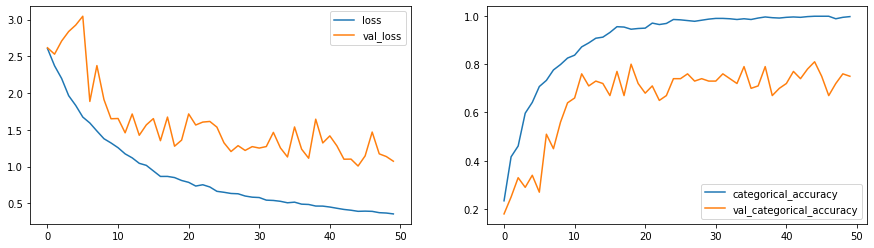

In [85]:
plot(history1)

In [86]:
df1 = model_result("Model_12_LSTM",history1.history['categorical_accuracy'][-1], history1.history['loss'][-1] , history1.history['val_categorical_accuracy'][-1], history1.history['val_loss'][-1])
model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

                      Model Name  Model Accuracy  Model Loss  Val Accuracy  \
0                    Model_1_SGD       65.820897  429.153824     50.999999   
0               Model_2_CNN_LSTM       77.761191   67.165470     62.000000   
0          Model_3_CNN_LSTM_Tune       96.865672   20.883286     66.000003   
0                Model_4_CNN_RNN       98.358208   11.060181     76.999998   
0                Model_5_CNN_GRU       88.955224   35.587654     79.000002   
0         Model_6_CNN_GRU_Tuning       65.671641   83.744723     31.999999   
0                 Model_7_Add_HL       90.149254  439.155579     76.999998   
0     Model_8_CNN_RNN_Add_Tuning       96.119404   17.363428     70.999998   
0  Model_9_LSTM_Transferlearning       98.358208   10.792203     80.000001   
0  Model_10_GRU_Transferlearning       97.611940   11.368181     77.999997   
0                   Model_11_GRU       98.955226   36.311457     69.999999   
0                  Model_12_LSTM       99.701494   35.676077    

### From above table, the Model_9_LSTM_Transferlearning comes out to be the best as it has a very good training accuracy(98.35) as well as validation accuracy(80)